# PARTE 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse

from typing import *
from collections import Counter
import math
import re

# Scikit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import *
from sklearn.tree import *
from sklearn.metrics import *

from Levenshtein import distance

In [2]:
df = pd.read_csv("dataset_pishing.csv")
df

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


In [3]:
df.describe()

,url,status
count,11430,11430
unique,11429,2
top,http://e710z0ear.du.r.appspot.com/c:/users/use...,legitimate
freq,2,5715


### Observaciones etiquetadas en la columna status como “legit” y como “pishing”. 

In [4]:
df["status"].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

### ¿Está balanceado el dataset?
 En este caso, se puede observar que el dataset si esta balanceado, pues hay la misma cantidad de elementos para ambos casos (legitimate, phishing)

### 1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?
En este caso, poder analizar la URL tiene mas beneficios, ya que al final, el tiempo de vida o caracteristicas no proveen suficiente informacion.
El dominio pudo tener modificaciones, en cuanto deploys o bien, traslado a una nueva URL, lo cual no deja mucha informacion para poder 
determinar que lo es. La pagina puede tener sus propias caracteristicas, pero esas pudieron ser hechas con fin de la misma, como si fuera
su proposito, lo cual sigue siendo ambiguo. Con respecto a la URL, es mas fiel, pues a mi parecer, debe tener un nombre coherente con lo que 
es la misma pagina, ya que mayormente, las paginas de phishing tiene alteraciones sutiles, pero las posee, lo cual, esa simple alteracion
puede levantar alarmas. Porque tener un dominio mal escrito? Acaso ese es el proposio? No tiene sentido que el dominio tenga un mal nombre
pues es la marca de la misma empresa. Algo a destacar, y que no habia tomado en cuenta, es que tambien, es mucho mas facil analizar URLs que los 
sitios perse, pues es mas sencillo solo analizar texto, que cantidades enormes de texto que representa una pagina, lo cual, lo vuelve costoso.

### 2. ¿Qué características de una URL son más prometedoras para la detección de phishing?
Modificaciones en el nombre, o bien, caracteres totalmente desvariados, como una longitud totalmente fuera de lo normal. Protocoloes que no tiene seguridad
o que no son recomendables o bien, puertos. Tambien, acortamiento de la misma URL, lo cual es sumamente sospechoso y tambien, como parte de la longitud
seria el paso de parametros sospechosos.


En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original.
Incluya dentro de las quince funciones, la entropía de Shanon y relativa.

# 1. Longitud de la URL

In [5]:
def url_length(url: str):
	return len(url)

# 2. Longitud del dominio

In [6]:
def domain_length(url: str):
	domain = url.split('//')[-1].split('/')[0]
	return len(domain)

# 3. Número de subdominios

In [7]:
def count_subdomains(url: str):
	domain = url.split('//')[-1].split('/')[0]
	return domain.count('.')

# 4. Presencia de protocolo HTTPS

In [8]:
def has_https(url: str):
	return 1 if url.startswith('https://') else 0

# 5. Presencia de acortadores de URL

In [9]:
def is_shortened(url: str):
	shorteners = ['bit.ly', 'tinyurl.com', 'goo.gl']
	return 1 if any(shortener in url for shortener in shorteners) else 0

# 6. Presencia de direcciones IP

In [10]:
def has_ip_address(url: str):
	pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
	return 1 if re.search(pattern, url) else 0

# 7. Número de parámetros en la URL

In [11]:
def count_parameters(url: str):
	return url.count('?') + url.count('&')

# 8. Presencia de palabras clave sospechosas

In [12]:
def has_suspicious_keywords(url: str):
	keywords = ['login', 'account', 'verify', 'secure', 'bank']
	return 1 if any(keyword in url for keyword in keywords) else 0

# 9. Uso de caracteres especiales

In [13]:
def count_special_chars(url: str):
	special_chars = ['@', '-', '_', '!', '?', '=', '&']
	return sum(url.count(char) for char in special_chars)

# 10. Entropía de Shannon

In [14]:
def shannon_entropy(url: str):
	freq = Counter(url)
	total = len(url)
	entropy = -sum((count / total) * math.log2(count / total) for count in freq.values())
	return entropy

# 11. Entropía relativa

In [15]:
def relative_entropy(url: str):
	max_entropy = math.log2(len(set(url)))
	return shannon_entropy(url) / max_entropy if max_entropy != 0 else 0

# 12. Longitud de la ruta

In [16]:
def path_length(url: str):
	path = url.split('//')[-1].split('/')[1:]
	return len('/'.join(path))

# 13. Presencia de puertos no estándar

In [17]:
def has_non_standard_port(url: str):
	return 1 if re.search(r':\d+', url) else 0

# 14. Similitud con dominios conocidos

In [18]:
def domain_similarity(url: str, legitimate_domains: List[str]):
	domain = url.split('//')[-1].split('/')[0]
	min_distance = min(distance(domain, legit) for legit in legitimate_domains)
	return min_distance

In [19]:
def levenshtein_distance(s1, s2):
	# Crear una matriz de tamaño (len(s1) + 1) x (len(s2) + 1)
	rows = len(s1) + 1
	cols = len(s2) + 1
	dist_matrix = [[0 for _ in range(cols)] for _ in range(rows)]

	# Inicializar la primera columna de la matriz
	for i in range(1, rows):
		dist_matrix[i][0] = i

	# Inicializar la primera fila de la matriz
	for j in range(1, cols):
		dist_matrix[0][j] = j

	# Calcular la distancia de Levenshtein
	for i in range(1, rows):
		for j in range(1, cols):
			if s1[i - 1] == s2[j - 1]:
				cost = 0  # No hay costo si los caracteres son iguales
			else:
				cost = 1  # Costo de sustitución

			# Calcular el mínimo entre inserción, eliminación y sustitución
			dist_matrix[i][j] = min(
				dist_matrix[i - 1][j] + 1,      # Eliminación
				dist_matrix[i][j - 1] + 1,      # Inserción
				dist_matrix[i - 1][j - 1] + cost  # Sustitución
			)

	# La distancia de Levenshtein es el valor en la esquina inferior derecha de la matriz
	return dist_matrix[-1][-1]

s1 = "kitten"
s2 = "sitting"
distance = levenshtein_distance(s1, s2)
print(f"Distancia de Levenshtein entre '{s1}' y '{s2}': {distance}")

Distancia de Levenshtein entre 'kitten' y 'sitting': 3


# 15. Presencia de codificación URL

In [20]:
def has_url_encoding(url: str):
	return 1 if '%' in url else 0

In [21]:
df.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


# Seleccion de caracteristicas
En la exploración de datos, determine las columnas que son constantes, o que no tienen una varianza
alta con la columna status. Elimine las características repetidas o irrelevantes para la clasificación de
un sitio de phishing. Verifique que no posee observaciones repetidas. Apóyese con la visualización de
características y correlación para seleccionar las características más importantes para clasificar una
URL legítima de una URL de phishing.

In [22]:
def extract_features(url):
	parsed_url = urlparse(url)
	
	return {
		"url": url,
		"url_length": len(url),  # Longitud de la URL
		"num_digits": sum(c.isdigit() for c in url),  # Cantidad de números
		"num_special_chars": sum(c in "!@#$%^&*()_+-=,./<>?" for c in url),  # Caracteres especiales
		"has_https": 1 if parsed_url.scheme == "https" else 0,  # HTTPS o no
		"num_subdomains": len(parsed_url.netloc.split(".")) - 2,  # Cantidad de subdominios
		"has_login": 1 if "login" in url.lower() else 0,  # Si tiene la palabra "login"
		"has_secure": 1 if "secure" in url.lower() else 0,  # Si tiene "secure"
		"has_bank": 1 if "bank" in url.lower() else 0,  # Si tiene "bank"
		"has_ip": 1 if re.match(r"^\d{1,3}(\.\d{1,3}){3}", parsed_url.netloc) else 0,  # Si tiene una dirección IP
	}

# Aplicar la función a cada URL y convertirla en un DataFrame
features = df["url"].apply(extract_features).apply(pd.Series)

# Unir las características con la columna "status"
df_final = pd.concat([features,df["status"]], axis=1)

# Ver las primeras filas
df_final.to_csv("caracteristicas.csv")

### 3. ¿Qué columnas o características fueron seleccionadas y por qué?
En este caso, se tomaron en cuenta en base a las 15 funcionas dterminadas previamete.
- Longitud de la URL
- Cantidad de caracteres especiales (/, -, _, ?, &, etc.)
- Verificar si hay palabras clave, tales como logint, id, secure, bank, etc
- Si es https o no
- Cantidad de subdominios
- Presencia de IP en URL
Se consideraron estas, para solo analizar lo que es de interes y no informacion de mas, ya que al final, hay cierta informacion que no aportaria
informacion util para el analisis

Con respecto a las que son phising y legitimas, se puede observar que son mas largas las de phishing que las legitimas, por ello se consideraron los anteriores caracteristicas.

# PARTE 2

Separación de datos
- Datos de entrenamiento: 55%
- Datos de validación: 15%
- Datos de prueba: 30%
- Almacene cada dataset como un archivo .csv

Implementación
Implemente dos modelos de Machine Learning (a su discreción) para la clasificación de phishing.
Muestre y explique los valores obtenidos de las siguientes métricas para los datos de validación y
pruebas, para cada modelo, en base al contexto del problema (detección de Pishing).
- Matriz de confusión
- Precision
- Recall
- Curva ROC
- AUC

In [26]:
df.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate



Evaluación para SVM:
Matriz de confusión (Validación):
 [[809  48]
 [ 76 781]]
Precisión (Validación): 0.9420989143546441
Recall (Validación): 0.911318553092182
Matriz de confusión (Prueba):
 [[1589  126]
 [ 157 1558]]
Precisión (Prueba): 0.9251781472684085
Recall (Prueba): 0.9084548104956268
AUC (Validación): 0.969174850806523
AUC (Prueba): 0.9580028729525961


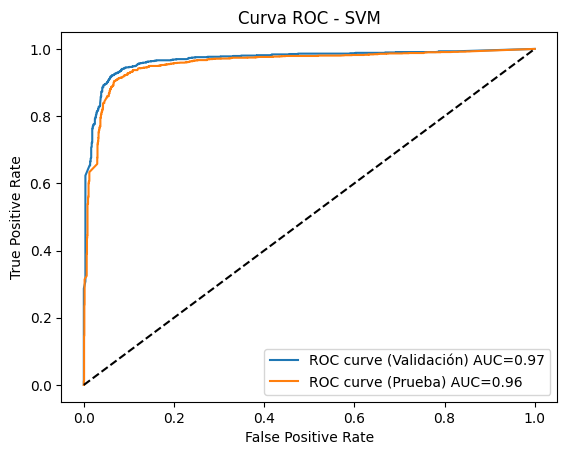


Evaluación para Decision Tree:
Matriz de confusión (Validación):
 [[546 311]
 [238 619]]
Precisión (Validación): 0.6655913978494624
Recall (Validación): 0.7222870478413069
Matriz de confusión (Prueba):
 [[1122  593]
 [ 441 1274]]
Precisión (Prueba): 0.6823781467595073
Recall (Prueba): 0.7428571428571429
AUC (Validación): 0.6796966161026838
AUC (Prueba): 0.698542274052478


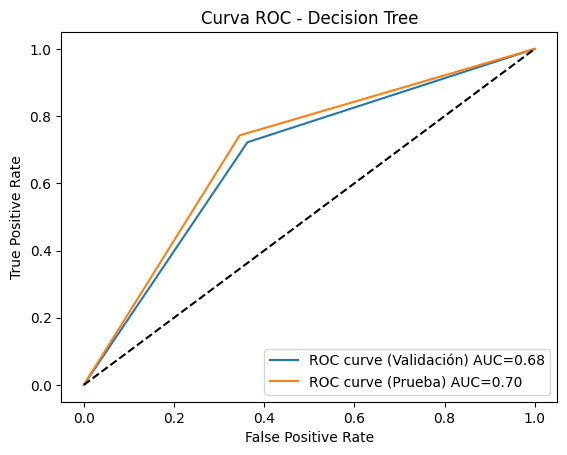

In [30]:
# Dividir los datos
train_size, val_size, test_size = 0.55, 0.15, 0.30
train_data, temp_data = train_test_split(df, test_size=(1-train_size), stratify=df['status'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size+val_size), stratify=temp_data['status'], random_state=42)

# Guardar datasets en CSV
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

# Convertir etiquetas a valores numéricos
label_mapping = {'legitimate': 0, 'phishing': 1}
df['status'] = df['status'].map(label_mapping)

# Vectorización de URLs
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['url'])
X_val = vectorizer.transform(val_data['url'])
X_test = vectorizer.transform(test_data['url'])

y_train = train_data['status'].map(label_mapping)
y_val = val_data['status'].map(label_mapping)
y_test = test_data['status'].map(label_mapping)

# Entrenar modelos
svm_model = SVC(probability=True)
dt_model = DecisionTreeClassifier()

svm_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Evaluación de modelos
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
	y_val_pred = model.predict(X_val)
	y_test_pred = model.predict(X_test)
	
	y_val_prob = model.predict_proba(X_val)[:, 1]
	y_test_prob = model.predict_proba(X_test)[:, 1]
	
	# Métricas
	print(f"\nEvaluación para {model_name}:")
	print("Matriz de confusión (Validación):\n", confusion_matrix(y_val, y_val_pred))
	print("Precisión (Validación):", precision_score(y_val, y_val_pred))
	print("Recall (Validación):", recall_score(y_val, y_val_pred))
	
	print("Matriz de confusión (Prueba):\n", confusion_matrix(y_test, y_test_pred))
	print("Precisión (Prueba):", precision_score(y_test, y_test_pred))
	print("Recall (Prueba):", recall_score(y_test, y_test_pred))
	
	# Curva ROC y AUC
	fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
	fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
	auc_val = auc(fpr_val, tpr_val)
	auc_test = auc(fpr_test, tpr_test)
	
	print("AUC (Validación):", auc_val)
	print("AUC (Prueba):", auc_test)
	
	plt.figure()
	plt.plot(fpr_val, tpr_val, label=f'ROC curve (Validación) AUC={auc_val:.2f}')
	plt.plot(fpr_test, tpr_test, label=f'ROC curve (Prueba) AUC={auc_test:.2f}')
	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title(f'Curva ROC - {model_name}')
	plt.legend(loc='lower right')
	plt.show()

# Evaluar modelos
evaluate_model(svm_model, X_val, y_val, X_test, y_test, "SVM")
evaluate_model(dt_model, X_val, y_val, X_test, y_test, "Decision Tree")

### 4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?
Si un sitio legítimo es identificado erróneamente como phishing, puede generar varias consecuencias negativas. En primer lugar, los usuarios podrían perder confianza en el sistema, ya que verían que está bloqueando páginas que en realidad son seguras. Esto también puede afectar a las empresas, que perderían visitas y posibles clientes, impactando sus ingresos. Además, los usuarios podrían sentirse frustrados al no poder acceder al sitio que necesitan, obligándolos a buscar alternativas y afectando su experiencia de navegación.

### 5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?
El impacto de no detectar un sitio de phishing tiene un resultado mucho más grave. Si el sitio fraudulento pasa como legítimo, los usuarios pueden ser engañados para que ingresen datos sensibles, como contraseñas o información bancaria, lo que puede derivar en fraudes y robos de identidad. También podría abrir la puerta a malware y otros ataques cibernéticos. Además, la reputación del sistema de detección se vería comprometida, ya que perdería credibilidad al permitir el acceso a páginas peligrosas.

### 6. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?
El principal riesgo es no detectar un sitio de phishing (falsos negativos), por lo que la métrica más importante sería el Recall o Sensibilidad. Esta métrica mide qué tan bien el modelo identifica los sitios fraudulentos y minimiza los casos en los que deja pasar una amenaza. Aunque la Precisión también es relevante, enfocarse demasiado en ella podría aumentar los falsos negativos, lo cual es riesgoso. Otra métrica útil sería el AUC-ROC, ya que permite evaluar el equilibrio entre Precisión y Recall en diferentes umbrales de decisión.

### 7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?
El SVM mostró métricas superiores en todos los aspectos. AUC (Área Bajo la Curva ROC): En validación obtuvo 0.97 y en prueba 0.96, lo que indica una excelente capacidad para diferenciar entre sitios legítimos y de phishing.
Precisión y Recall: En la fase de prueba, el SVM alcanzó una precisión de 0.925 y un recall de 0.908, lo que significa que logra identificar correctamente la mayoría de los sitios de phishing con pocos falsos positivos.

Por otro lado, el Decision Tree obtuvo un AUC significativamente menor (0.68 en validación y 0.70 en prueba), lo que sugiere que tiene una menor capacidad para distinguir entre clases. Además, sus valores de precisión (0.682) y recall (0.742) en la prueba son más bajos, lo que lo hace menos efectivo en la detección de sitios de phishing.

Posiblemente se debio a un sobreajuste del mismo modelo con la reparticion de la data, llevando a tales resultados.


### 8. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes  ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails,  un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y  cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?



In [1]:
# Datos iniciales
total_emails = 50000
porcentaje_phishing = 0.15
emails_phishing = int(total_emails * porcentaje_phishing)
emails_legitimos = total_emails - emails_phishing

# Métricas del modelo SVM (prueba)
recall = 0.908  # Sensibilidad (detección de phishing correctamente)
precision = 0.925  # Precisión (proporción de alarmas reales sobre las generadas)

# Cálculo de verdaderos positivos (VP) y falsos negativos (FN)
VP = int(emails_phishing * recall)
FN = emails_phishing - VP

# Cálculo de falsos positivos (FP) usando la ecuación de precisión
FP = int((VP / precision) - VP)

# Cálculo de verdaderos negativos (VN)
VN = emails_legitimos - FP

# Total de alarmas generadas
total_alarmas = VP + FP

# Imprimir resultados
print(f"Total de emails analizados: {total_emails}")
print(f"Total de emails phishing: {emails_phishing}")
print(f"Total de emails legítimos: {emails_legitimos}\n")

print(f"Verdaderos Positivos (VP): {VP}")
print(f"Falsos Negativos (FN): {FN}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Verdaderos Negativos (VN): {VN}\n")

print(f"Total de alarmas generadas: {total_alarmas}")
print(f"Alarmas positivas correctas (VP): {VP}")
print(f"Alarmas falsas (FP): {FP}")


Total de emails analizados: 50000
Total de emails phishing: 7500
Total de emails legítimos: 42500

Verdaderos Positivos (VP): 6810
Falsos Negativos (FN): 690
Falsos Positivos (FP): 552
Verdaderos Negativos (VN): 41948

Total de alarmas generadas: 7362
Alarmas positivas correctas (VP): 6810
Alarmas falsas (FP): 552


El modelo SVM generaría un total de 7,362 alarmas (es decir, emails clasificados como phishing). De estas:
- 6,810 serían alarmas positivas correctas (verdaderos positivos, VP), es decir, correos de phishing detectados correctamente.
- 552 serían falsas alarmas (falsos positivos, FP), es decir, correos legítimos que el modelo clasificó erróneamente como phishing.

Por otro lado, habría:
- 690 correos de phishing que el modelo no detectó (falsos negativos, FN), lo que representa un posible riesgo de seguridad.
- 41,948 correos legítimos clasificados correctamente (verdaderos negativos, VN).

#### ¿Funciona el modelo para el balance de clases propuesto?

El modelo tiene un buen desempeño, ya que logra detectar la mayoría de los correos de phishing (90.8% de recall) y genera una cantidad relativamente baja de falsas alarmas (1.3% de los correos legítimos son marcados erróneamente). Sin embargo, aún deja pasar 690 correos peligrosos, lo que puede ser un riesgo para la empresa.

#### ¿Cómo reducir las falsas alarmas?
Para poder reducirlo, se considera:
- Ajustar el umbral de decisión:
Se podría modificar el umbral de clasificación del modelo para ser más conservador con las detecciones. Esto reduciría los falsos positivos, aunque podría aumentar los falsos negativos.

- Filtrado adicional o modelo híbrido:
Implementar un segundo modelo de verificación (por ejemplo, basado en análisis semántico o reputación de dominios) para validar los casos dudosos antes de generar una alerta.

- Mejorar las características del modelo:
Incluir más información en la detección, como análisis de contenido, patrones de remitentes o análisis de enlaces sospechosos, para mejorar la precisión.

- Sistema de revisión manual:
Para empresas con alto riesgo, los correos detectados como phishing podrían someterse a una revisión manual antes de ser bloqueados automáticamente.

En conclusión, el modelo es funcional, pero si se busca reducir las falsas alarmas sin comprometer la seguridad, se podrian implementar estrategias como ajuste de umbral, un modelo híbrido o un sistema de verificación adicional.